In [1]:
# import packages
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import community
import sqlite3

# Load data
con = sqlite3.connect("data/database.sqlite")
cur = con.cursor()
query = """
SELECT ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text FROM Reviews
"""
data = pd.read_sql_query(query, con)

# User-Product Graph

In [11]:
# Load graph
UP = pickle.load(open('graphs/user_product_graph.pickle', 'rb'))
UP = UP.subgraph(max(nx.connected_components(UP), key=len))

In [125]:
# Helper function for plotting histograms
def prepare_hist(graph):
    degrees = [d for _, d in graph.degree]

    v = [i - 0.5 for i in range(np.min(degrees), np.max(degrees) + 2)]
    h = np.histogram(degrees, v)[0]

    x = [np.mean([v[i], v[i+1]]) for i in range(len(v)-1)]
    return x, h

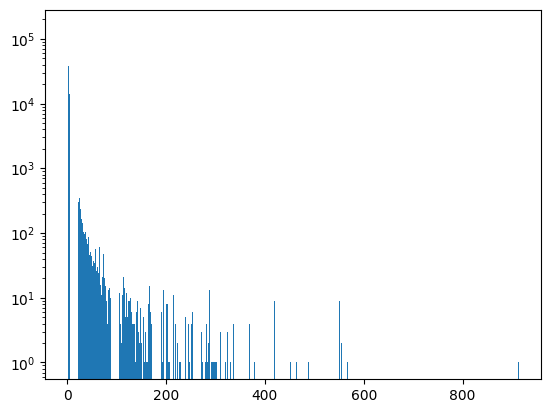

In [102]:
# Plot degree histogram
x, h = prepare_hist(UP)

plt.bar(x, h)
plt.yscale('log')
plt.show()

In [14]:
# Find ID of the biggest hub
[p for p, d in UP.degree if d > 800]

['B007JFMH8M']

In [15]:
# data.loc[data.ProductId == 'B007JFMH8M'] # cookies

The biggest hub (most reviewed product) appears to be cookies

In [16]:
# Extract communitites
UP_undirected = nx.to_undirected(UP)
partition = nx.community.louvain_communities(UP_undirected, seed=123)

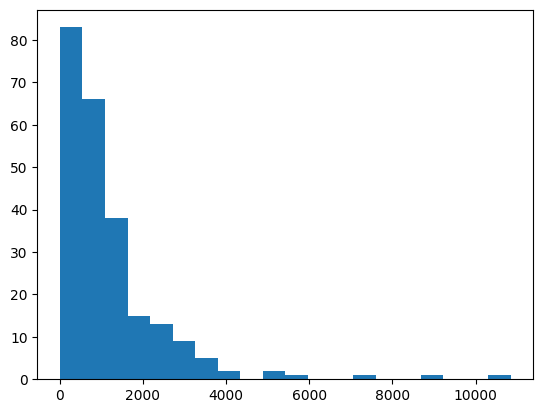

In [17]:
# Plot histogram of the partition length
partition_len = [len(p) for p in partition]

plt.hist(partition_len, 20)
plt.show()

Similarly to the Product-Product case, we have planty of small communitites

In [18]:
# Find smallest communities with at least 3 products
partition = sorted(partition, key=len)
partition_products = [p for p in partition if sum([e.startswith('B') for e in p]) >= 3]

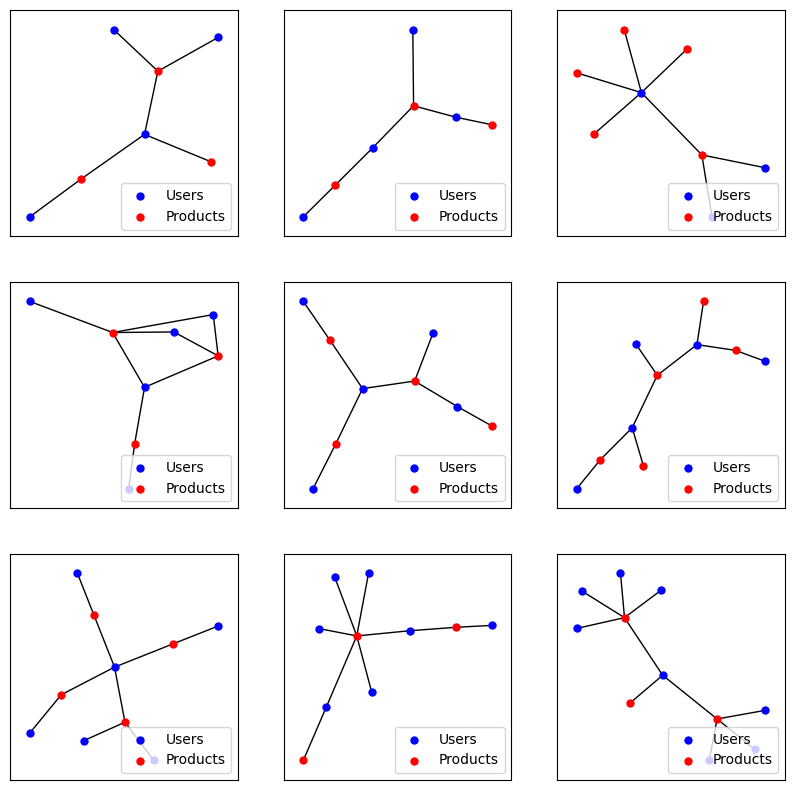

In [19]:
# Plot partitions extracted in previous chunk
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    p = np.array(list(partition_products[i]))
    c = [e.startswith('B') for e in p]
    not_c = [not e for e in c]
    pos = nx.spring_layout(UP.subgraph(p))
    nx.draw_networkx_nodes(UP.subgraph(p), pos=pos, nodelist=p[not_c], node_color='blue', label='Users', node_size=25)
    nx.draw_networkx_nodes(UP.subgraph(p), pos=pos, nodelist=p[c], node_color='red', label='Products', node_size=25)
    nx.draw_networkx_edges(UP.subgraph(p), pos=pos)
    plt.legend(loc='lower right')

plt.show()

Visually apealing, but difficult to extract value from.

In [20]:
# Compute modularity
nx.community.modularity(UP_undirected, partition)

0.8461919245370795

Modularity is much higher then in Product-Product case.

In [28]:
# Get the most central items
dict(sorted(nx.degree_centrality(UP).items(), key=lambda item: -item[1]))

{'B007JFMH8M': 0.003381544102668568,
 'B003B3OOPA': 0.002307450137965518,
 'B002QWP89S': 0.002255597325876405,
 'B0026RQTGE': 0.002255597325876405,
 'B002QWHJOU': 0.002255597325876405,
 'B002QWP8H0': 0.002255597325876405,
 'B001EO5Q64': 0.002100038889609067,
 'B000KV61FC': 0.002055593622104113,
 'B000KV7ZGQ': 0.002055593622104113,
 'B0013NUGDE': 0.002040778532935795,
 'B007M83302': 0.002040778532935795,
 'B000VK8AVK': 0.002040778532935795,
 'B001RVFEP2': 0.002040778532935795,
 'B0026KNQSA': 0.002040778532935795,
 'B007M832YY': 0.002040778532935795,
 'B0026KPDG8': 0.002040778532935795,
 'B001RVFERK': 0.002040778532935795,
 'B006HYLW32': 0.002040778532935795,
 'B000NMJWZO': 0.00200744458230708,
 'B0090X8IPM': 0.0019629993148021258,
 'B003GTR8IO': 0.0019629993148021258,
 'B005K4Q37A': 0.0019407766810496491,
 'B005K4Q4LK': 0.0019407766810496491,
 'B005K4Q1YA': 0.0019407766810496491,
 'B005K4Q34S': 0.0019407766810496491,
 'B000UBD88A': 0.0019000351858367748,
 'B0013A0QXC': 0.001900035185836

Already mentioned cookies have a big advantage compared to the rest of items.

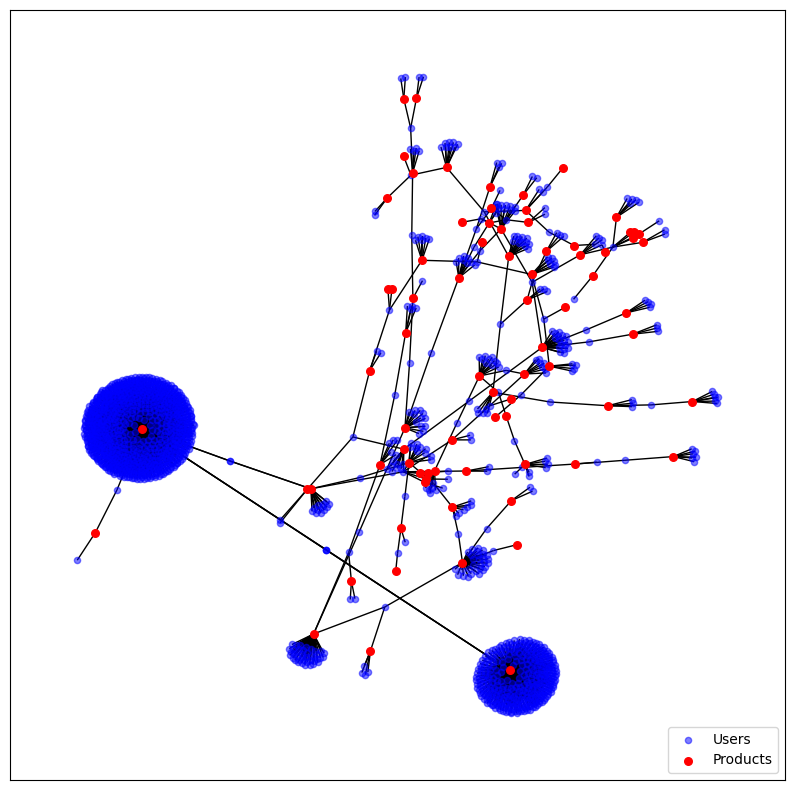

In [88]:
# Plot the community where the cookies belong to
big_partition = [p for p in partition if 'B007JFMH8M' in p][0]

p = np.array(list(big_partition))
c = [e.startswith('B') for e in p]
not_c = [not e for e in c]
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(UP.subgraph(p))
nx.draw_networkx_nodes(UP.subgraph(p), pos=pos, nodelist=p[not_c], node_color='blue', label='Users', node_size=20, alpha=0.5)
nx.draw_networkx_nodes(UP.subgraph(p), pos=pos, nodelist=p[c], node_color='red', label='Products', node_size=30)
nx.draw_networkx_edges(UP.subgraph(p), pos=pos)
plt.legend(loc='lower right')
plt.show()

In [1]:
# Compute mean score for cookies
data.loc[data.ProductId == 'B007JFMH8M'].Score.mean()
# Count number of Products in partition (Uncomment to check mean score)
counts = data.loc[data.ProductId.isin(p[c])].groupby(['ProductId']).count().Id #.mean('Score')
# Check mean score for the dataset
data.Score.mean()

# Product-Product graph

In [ ]:
# Load Graph and extract giant connected component
G = pickle.load(open('graphs/product_product_graph.pickle', 'rb'))
G = G.subgraph(max(nx.connected_components(G), key=len))

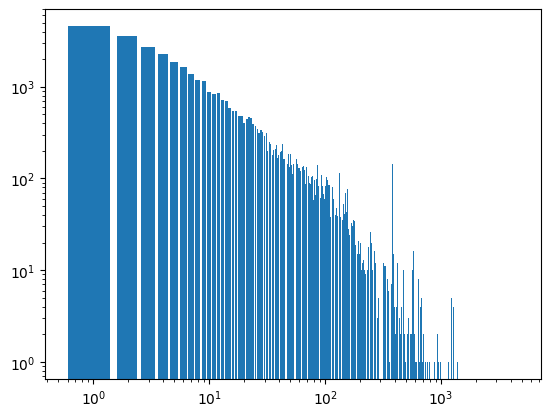

In [126]:
# Plot histogram of degree distribution in log-log scale
x, h = prepare_hist(G)

plt.bar(x, h)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [4]:
# Get product IDs for the most central products
[p for p, d in G.degree if d > 4000]

['B0041NYV8E', 'B002IEVJRY', 'B002IEZJMA']

In [5]:
# https://www.amazon.com/product-reviews/ProductId to access product reviews
# data.loc[data.ProductId == 'B002IEZJMA'] # coffee
# data.loc[data.ProductId == 'B002IEVJRY'] # iced coffee
# data.loc[data.ProductId == 'B0041NYV8E'] # ginger drink

Quick check in portal shows that the most central items are coffee, iced coffee, and ginger drink

In [6]:
# Extract communitites with Louvain method (undirected graph)
G_undirected = nx.to_undirected(G)
partition = nx.community.louvain_communities(G_undirected, seed=123)

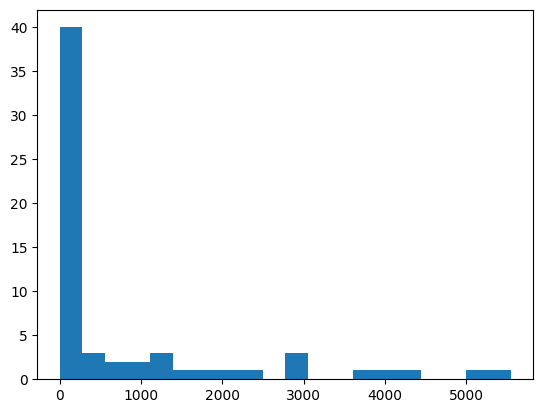

In [7]:
# Plot histogram of length of partitions
partition_len = [len(p) for p in partition]

plt.hist(partition_len, 20)
plt.show()

This graph has over 60 communities, most of which are very small.

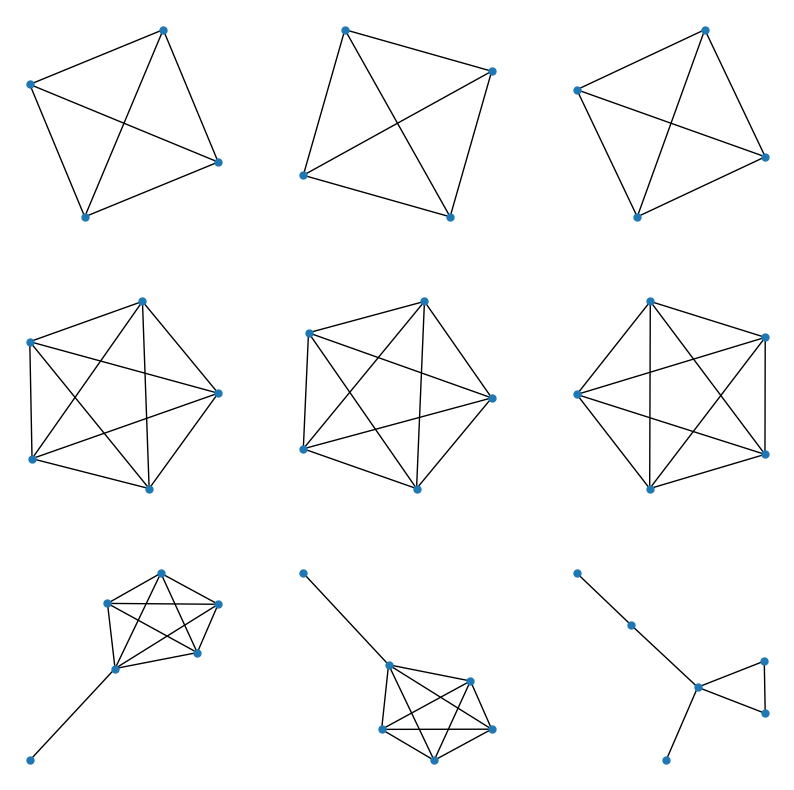

In [8]:
# Draw smallest community subgraphs
partition = sorted(partition, key=len)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    nx.draw(G.subgraph(partition[i]), node_size=25)

The community partition does not seem to be very interesting to analyse

In [9]:
# Compute modularity value
nx.community.modularity(G_undirected, partition)

0.46983382775647786

In [124]:
# Prepare product and user degree lists
products = [node for node, data in UP.nodes(data=True) if data['bipartite'] == 1]
p_degree = [UP.degree[product] for product in products]

users = [node for node, data in UP.nodes(data=True) if data['bipartite'] == 0]
u_degree = [UP.degree[user] for user in users]

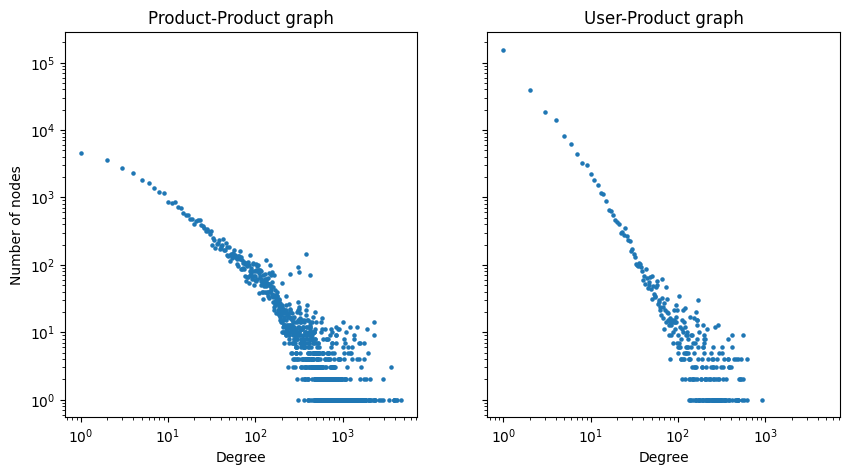

In [160]:
# Plot Product-Product and User-Product degree histograms (uncomment for Users and Product from User-Product)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

x, h = prepare_hist(G)
axes[0].scatter(x, h, s=5)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylabel('Number of nodes')
axes[0].set_xlabel('Degree')
axes[0].set_title('Product-Product graph')

# x, h = prepare_hist(p_degree)
# axes[1].scatter(x, h, s=5)
# axes[1].set_xlabel('Degree')
# axes[1].set_title('Products in User-Product graph')

# x, h = prepare_hist(u_degree)
# axes[2].scatter(x, h, s=5)
# axes[2].set_xlabel('Degree')
# axes[2].set_title('Users in User-Product graph')

x, h = prepare_hist(UP)
axes[1].scatter(x, h, s=5)
axes[1].set_xlabel('Degree')
axes[1].set_title('User-Product graph')

plt.show()

As expected we have higher degrees in Product-Product graph

In [150]:
# Compute powerlaw exponents
import powerlaw
print(powerlaw.Fit([d for _, d in G.degree], verbose=0).alpha)
print(powerlaw.Fit(p_degree, verbose=0).alpha)
print(powerlaw.Fit(u_degree, verbose=0).alpha)
print(powerlaw.Fit([d for _, d in UP.degree], verbose=0).alpha)

3.052486978459307%
2.1729843553485875
3.339540503047238%
2.4618002204658005


Product-Product is Random Graph regime, User-Product in Small-World

In [159]:
# Print highest degrees
sorted(G.degree, key=lambda x: x[1], reverse=True)

[('B002IEZJMA', 4655),
 ('B002IEVJRY', 4222),
 ('B0041NYV8E', 4078),
 ('B006MONQMC', 3931),
 ('B002LANN56', 3905),
 ('B001VJ0B0I', 3863),
 ('B005HG9ESG', 3606),
 ('B005HG9ERW', 3606),
 ('B005HG9ET0', 3606),
 ('B0051COPH6', 3368),
 ('B004E4EBMG', 2915),
 ('B0090X8IPM', 2885),
 ('B003GTR8IO', 2885),
 ('B004E4CCSQ', 2762),
 ('B0061IUIDY', 2631),
 ('B004BKLHOS', 2363),
 ('B001LGGH40', 2344),
 ('B004E4HUMY', 2296),
 ('B000G6RYNE', 2288),
 ('B0058AMY74', 2288),
 ('B0012XBD7I', 2288),
 ('B000G6MBUA', 2288),
 ('B00472I5A4', 2288),
 ('B000LKXBL4', 2288),
 ('B0058AMY10', 2288),
 ('B0058AMYTC', 2288),
 ('B0058AMY5G', 2288),
 ('B000G6O2QG', 2288),
 ('B000LKVD5U', 2288),
 ('B006WYSFZK', 2288),
 ('B004728MI4', 2288),
 ('B001SAXPEO', 2288),
 ('B0013NUGDE', 2275),
 ('B007M83302', 2275),
 ('B000VK8AVK', 2275),
 ('B001RVFEP2', 2275),
 ('B0026KNQSA', 2275),
 ('B007M832YY', 2275),
 ('B0026KPDG8', 2275),
 ('B001RVFERK', 2275),
 ('B006HYLW32', 2275),
 ('B004ZIER34', 2252),
 ('B001LG940E', 2102),
 ('B006J4MA

In this graph hubs are less impactful - graph is less interesting to analyze